In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

import json
import geopandas as gpd
from copy import deepcopy
import shapely
from shapely.geometry import Point,Polygon,LineString
import pyproj

### map of the 50 metro areas

In [2]:
# shape file for US metro areas
metromap = gpd.read_file("../data/shapes/tl_2019_us_cbsa/tl_2019_us_cbsa.shp")

In [3]:
# manipulations
metromap.set_geometry("geometry",inplace=True)

metromap["GEOID"] = metromap["GEOID"].astype(int)

In [4]:
# cbsa info table
cbsa_info = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

In [5]:
# manipulations
cbsa_info = cbsa_info.loc[:,["cbsacode", "short_name"]].drop_duplicates()
cbsa_info["selected"] = 1
cbsa_info["color"] = "darkblue"

In [10]:
# merge for plot
metromap = pd.merge(metromap, cbsa_info, left_on="GEOID", right_on="cbsacode", how="left")

In [11]:
# correction on the final dataframe
metromap["selected"] = metromap["selected"].fillna(0)
metromap["color"] = metromap["color"].fillna("lightgray")

In [12]:
# shape file for US states
usmap = gpd.read_file("../data/shapes/tl_2017_us_state/tl_2017_us_state.shp")

# manipulations
usmap.set_geometry("geometry",inplace=True)

### user numbers

In [89]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(degree_tab, users, left_on="user_id", right_on="user_id1", how="left")

# user count per cbsa
users_cbsa = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()

In [90]:
# METRODATA

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[users_cbsa["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

# merge user counts
metrodata = pd.merge(users_cbsa, metrodata, on="cbsacode")
metrodata = metrodata.sort_values(by=['rank'])

In [ ]:
### combination

# general
import matplotlib.patches as mpatches
plt.rcParams['font.size']=16
plt.rc('legend',fontsize=22)
fig, ax = plt.subplots(2,1, figsize = (15,15), constrained_layout=True)


# MAP
usmap.plot(ax=ax[0], color="white", edgecolor='dimgray')
metromap.plot(ax=ax[0], column="selected", color=metromap["color"], edgecolor='dimgray')
ax[0].set_xlim([-127,-66])
ax[0].set_ylim([24,50])
ax[0].axis('off')

top50metro = mpatches.Patch(color='darkblue', label='Top 50 metro areas')
allmetro = mpatches.Patch(color='lightgray', label='Metro areas')
ax[0].legend(handles=[top50metro, allmetro], loc='lower left')


# distribution
ax[1].bar(metrodata["short_name"], metrodata["user_id"], color="darkblue")
ax[1].set_xticklabels(labels="", rotation=90)
ax[1].grid()
# ax[1].semilogy()
ax[1].set_xticklabels(labels=metrodata['short_name'], rotation=90)
ax[1].set_ylabel("Observed users", size=22)

plt.show()
# plt.savefig('../fig/map_users_top50.png', dpi=300, bbox_inches='tight')

### data representativity -- users / population

In [2]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/original_files/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(degree_tab, users, left_on="user_id", right_on="user_id1", how="left")

# user count per cbsa
user_df = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()
user_df.columns = ["cbsacode", "nr_users"]

In [3]:
# add observed users to metrodata
metrodata = pd.read_csv('../data/original_files/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[user_df["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.reset_index()

# user counts
metrodata = pd.merge(metrodata, user_df, on="cbsacode", how="left")

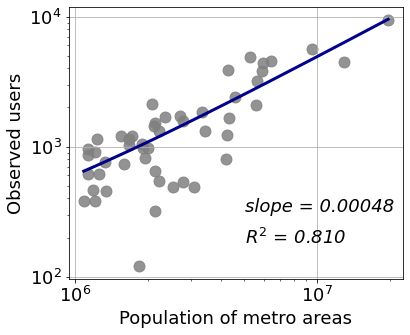

In [6]:
# SCATTER
plt.rcParams['font.size']=18
fig, ax = plt.subplots(figsize = (6,5))

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = (metrodata["population"]).values.reshape(-1, 1) 
Y = (metrodata["nr_users"]).values.reshape(-1, 1) 
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(metrodata.population, metrodata.nr_users, s=120, color='grey', alpha=0.85)
plt.plot(X, Y_pred, color='darkblue', linewidth=3)
plt.xlabel("Population of metro areas")
plt.ylabel("Observed users")
plt.loglog()
#plt.xlim([10**5.95, 10**7.3])
#plt.ylim([10**2.95, 10**4.5])

#slope = str("slope = " + linear_regressor.coef_)
plt.text(10**6.7, 10**2.5, ("slope = " + str(linear_regressor.coef_[0][0])[:7]), style='italic')
plt.text(10**6.7, 10**2.25, ("$R^2$ = " + str(r2_score(Y, Y_pred))[:5]), style='italic')

plt.grid()
plt.show()
#plt.savefig('../fig/revision_SI_population_users.png',density=300,bbox_inches='tight')

### data representativity -- income / BA

In [2]:
# population in diff income deciles
censusdata2012 = pd.read_csv("../data/original_files/censusdata_top50_2012.csv")

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

censusdata2012['geoid'] = censusdata2012.apply(create_geoid,axis=1)

# keep interesting columns
censusdata2012 = censusdata2012[['geoid', 'population', 'education_bachelor', 'income']]

# cleaning
censusdata2012 = censusdata2012[censusdata2012["income"]>1500]
censusdata2012["BA_share"] = censusdata2012["education_bachelor"] / censusdata2012["population"]


# add cbsacode to censusdata
userdata = pd.read_csv('../data/original_files/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_tract = userdata[["user_id", "tract_home"]]

temp1 = userdata[["cbsacode", "tract_home"]].rename(columns={"tract_home":"tract_id"})
temp2 = userdata[["cbsacode", "tract_work"]].rename(columns={"tract_work":"tract_id"})
temp = pd.concat([temp1, temp2]).drop_duplicates()
censusdata2012 = pd.merge(censusdata2012, temp, left_on="geoid", right_on="tract_id", how="left")

In [3]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/original_files/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)
print(degree_tab.shape)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# add census info to users
users = pd.merge(degree_tab, users, left_on="user_id", right_on="user_id1", how="left")
users = pd.merge(users, user_tract, on="user_id", how="left")
users = pd.merge(users, censusdata2012, left_on=["tract_home", "cbsacode"], right_on=["tract_id", "cbsacode"], how="left")
print(users.shape)

(86821, 2)
(86821, 11)


In [9]:
# log transfer
censusdata2012["log_income"] = np.log10(censusdata2012["income"] +1)
users["log_income"] = np.log10(users["income"] +1)
users = users.dropna()

print(censusdata2012.shape)
print(users.shape)

(38492, 8)
(86211, 12)


In [5]:
# not so elegant way to population weight the prepared plot
multi = np.array(censusdata2012["population"])

x = censusdata2012[["tract_id", "log_income"]].values
census_multi_income = pd.DataFrame(np.repeat(x, multi, axis=0))
census_multi_income.columns = ["tract_id", "log_income"]
census_multi_income = pd.merge(census_multi_income, temp, on="tract_id", how="left")
print(census_multi_income.shape)

x2 = censusdata2012[["tract_id", "BA_share"]].values
census_multi_BA = pd.DataFrame(np.repeat(x2, multi, axis=0))
census_multi_BA.columns = ["tract_id", "BA_share"]
census_multi_BA = pd.merge(census_multi_BA, temp, on="tract_id", how="left")
print(census_multi_BA.shape)

(173139696, 3)
(173139696, 3)


In [ ]:
# plot construction -- 820sec..

fig = plt.figure(figsize=(16,8), constrained_layout=True)
plt.rcParams['font.size'] = 15

ax = [0]*8
gs = GridSpec(2,6,figure=fig, height_ratios = [0.5,0.5]) # height_ratios = [0.2,0.2,0.3,0.2]

# grids
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[0,3:6])
ax[2] = fig.add_subplot(gs[1,0])
ax[3] = fig.add_subplot(gs[1,1])
ax[4] = fig.add_subplot(gs[1,2])
ax[5] = fig.add_subplot(gs[1,3])
ax[6] = fig.add_subplot(gs[1,4])
ax[7] = fig.add_subplot(gs[1,5])


# income -- all cbsas
sns.distplot(census_multi_income['log_income'], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
sns.distplot(users['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
# ax[0].set_xlabel("Income (log10)")
ax[0].set_xlabel("Income (log10) in census tract")
ax[0].set_ylabel("Probability density")

# BA -- all cbsas
sns.distplot(census_multi_BA['BA_share'], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[1])
sns.distplot(users['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[1])
ax[1].set_xlabel("Share of BA holders")
ax[1].set_xlabel("Share of BA holders in census tract")
ax[1].set_ylabel("Probability density")

# Detroit 19820
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==19820]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[2])
sns.distplot(users[users["cbsacode"]==19820]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[2])
ax[2].set_xlabel("Income (log10)")
ax[2].set_ylabel("Probability density")
ax[2].set_title("Detroit")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==19820]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[5])
sns.distplot(users[users["cbsacode"]==19820]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[5])
ax[5].set_xlabel("Share of BA holders")
ax[5].set_ylabel("Probability density")
ax[5].set_title("Detroit")

# New York 35620
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==35620]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[3])
sns.distplot(users[users["cbsacode"]==35620]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[3])
ax[3].set_xlabel("Income (log10)")
ax[3].set_ylabel("Probability density")
ax[3].set_title("New York")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==35620]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[6])
sns.distplot(users[users["cbsacode"]==35620]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[6])
ax[6].set_xlabel("Share of BA holders")
ax[6].set_ylabel("Probability density")
ax[6].set_title("New York")

# Boston 14460
sns.distplot(census_multi_income[census_multi_income["cbsacode"]==14460]["log_income"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[4])
sns.distplot(users[users["cbsacode"]==14460]['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[4])
ax[4].set_xlabel("Income (log10)")
ax[4].set_ylabel("Probability density")
ax[4].set_title("Boston")

sns.distplot(census_multi_BA[census_multi_BA["cbsacode"]==14460]["BA_share"], hist=False, kde=True,  color = 'grey',  kde_kws={'shade': True, 'linewidth': 3}, ax=ax[7])
sns.distplot(users[users["cbsacode"]==14460]['BA_share'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[7])
ax[7].set_xlabel("Share of BA holders")
ax[7].set_ylabel("Probability density")
ax[7].set_title("Boston")


# legend
custom_lines = [Line2D([0], [0], color='grey',  lw=8),Line2D([0], [0], color='darkblue', lw=8)]
labels = [ 'Census data', 'Observed users']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2, frameon=False, fontsize=15)


#plt.show()
plt.savefig('../fig/si_income_ba_repr.png',density=300,bbox_inches="tight")
# plt.savefig('../fig/si_income_ba_repr2.png',density=300,bbox_inches="tight")

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


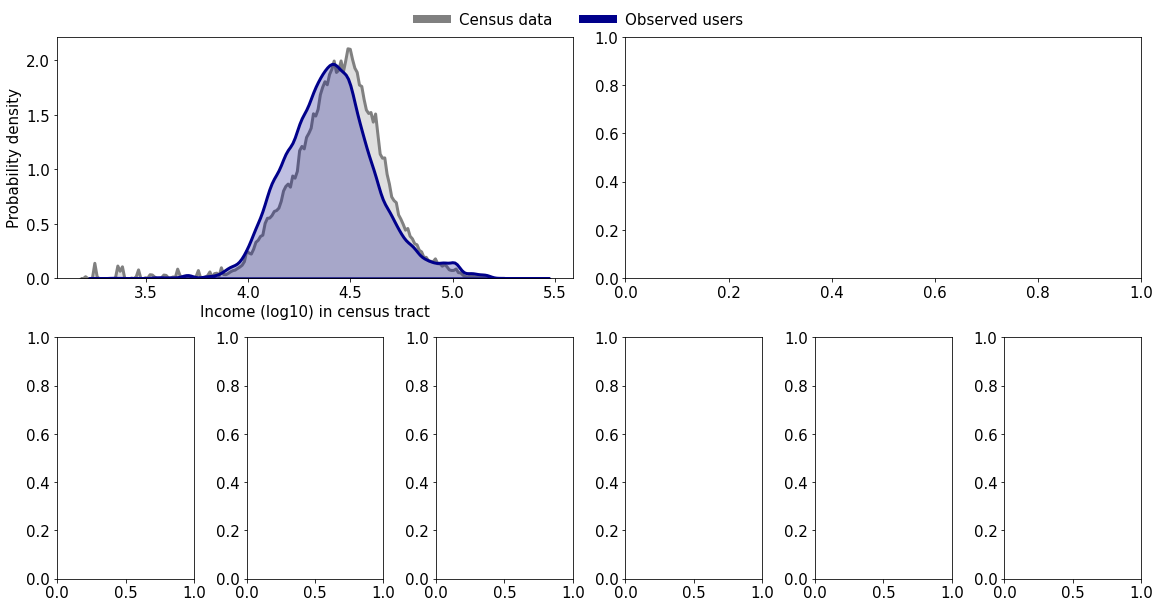

In [10]:
# plot construction -- test

fig = plt.figure(figsize=(16,8), constrained_layout=True)
plt.rcParams['font.size'] = 15

ax = [0]*8
gs = GridSpec(2,6,figure=fig, height_ratios = [0.5,0.5]) # height_ratios = [0.2,0.2,0.3,0.2]

# grids
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[0,3:6])
ax[2] = fig.add_subplot(gs[1,0])
ax[3] = fig.add_subplot(gs[1,1])
ax[4] = fig.add_subplot(gs[1,2])
ax[5] = fig.add_subplot(gs[1,3])
ax[6] = fig.add_subplot(gs[1,4])
ax[7] = fig.add_subplot(gs[1,5])


# income -- all cbsas
sns.distplot(census_multi_income['log_income'], hist=False, kde=True,  color = 'grey', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
sns.distplot(users['log_income'], hist=False, kde=True,  color = 'darkblue', kde_kws={'shade': True, 'linewidth': 3}, ax=ax[0])
# ax[0].set_xlabel("Income (log10)")
ax[0].set_xlabel("Income (log10) in census tract")
ax[0].set_ylabel("Probability density")



# legend
custom_lines = [Line2D([0], [0], color='grey',  lw=8),Line2D([0], [0], color='darkblue', lw=8)]
labels = [ 'Census data', 'Observed users']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2, frameon=False, fontsize=15)


plt.show()
# plt.savefig('../fig/si_income_ba_repr.png',density=300,bbox_inches="tight")
# plt.savefig('../fig/si_income_ba_repr2.png',density=300,bbox_inches="tight")

### lollipop on poor/rich user counts

In [2]:
# METRODATA

metrodata = pd.read_csv('../data/original_files/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").reset_index().sort_values(by="CENSUS2010POP", ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank", "CBSA":"cbsacode", "NAME":"name", "CENSUS2010POP":"population"}, axis=1, inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.iloc[:50,] # keep the top50 ONLY
# metrodata = metrodata.reset_index()

In [5]:
# degree data
degree_tab = pd.read_csv("../data/original_files/degree_tab_top50.csv.gz")

# user numbers by poor/rich group
metrodata["nr_poor"] = metrodata.index.map(degree_tab[degree_tab["poor"]==1].groupby("cbsacode")["user_id"].agg("count").to_dict())
metrodata["nr_rich"] = metrodata.index.map(degree_tab[degree_tab["poor"]==0].groupby("cbsacode")["user_id"].agg("count").to_dict())

<ipython-input-33-cccd962c1143>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=metrodata['short_name'], rotation=90)


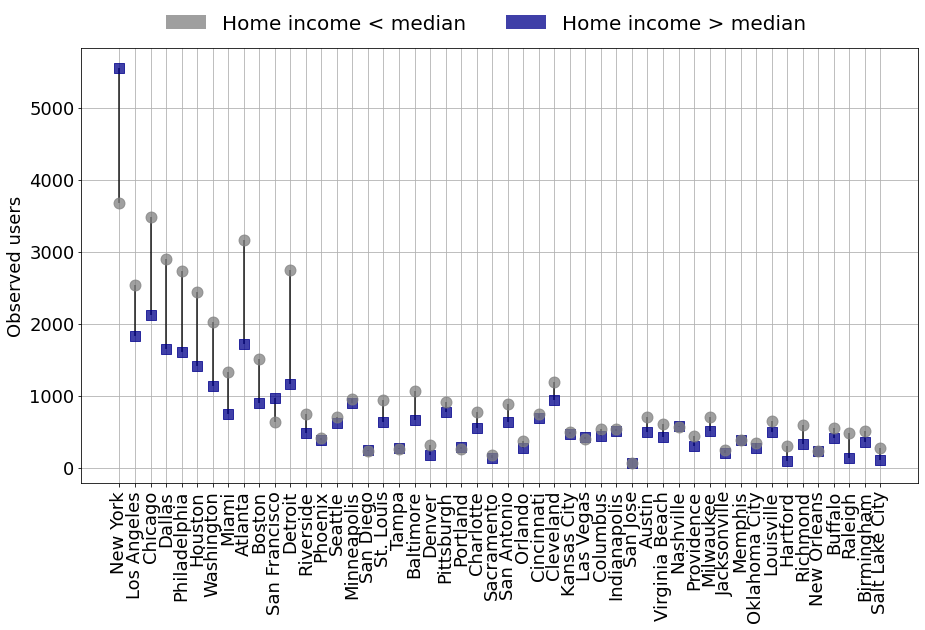

In [33]:
# plot 2
fig,ax = plt.subplots(1,1,figsize=(15,8), sharex=True)
plt.rcParams['font.size']=18


# avg share of friends -- cummulative
ax.vlines(x=metrodata['short_name'], ymin=metrodata['nr_poor'], ymax=metrodata['nr_rich'], color='black', alpha=0.9)
ax.scatter(metrodata['short_name'], metrodata['nr_rich'], color="darkblue", marker='s', s=120, alpha=0.75, zorder=2)
ax.scatter(metrodata['short_name'], metrodata['nr_poor'], color="grey", marker='o', s=120, alpha=0.75, zorder=2)
ax.set_xticklabels(labels="", rotation=90)
ax.grid()
#ax[0].set_ylim([0.2, 0.8])
ax.set_ylabel('Observed users')
ax.set_xticklabels(labels=metrodata['short_name'], rotation=90)

# legend
custom_lines = [Patch(facecolor='grey', alpha=0.75), Patch(facecolor='darkblue', alpha=0.75)]
labels = [ 'Home income < median', 'Home income > median']

plt.figlegend(custom_lines, labels, loc='upper center',
    bbox_to_anchor=(0.5, 0.97),
    ncol=2, frameon=False, fontsize=20)

plt.show()

In [17]:
metrodata.head()

,rank,name,population,short_name,nr_poor,nr_rich
cbsacode,,,,,,
35620,0,"New York-Newark-Jersey City, NY-NJ-PA",19567410,New York,3677,5551
31080,1,"Los Angeles-Long Beach-Anaheim, CA",12828837,Los Angeles,2531,1832
16980,2,"Chicago-Naperville-Elgin, IL-IN-WI",9461105,Chicago,3479,2116
19100,3,"Dallas-Fort Worth-Arlington, TX",6426214,Dallas,2895,1654
37980,4,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",5965343,Philadelphia,2735,1603


In [15]:
metrodata

,rank,name,population,short_name,nr_poor
cbsacode,,,,,
35620,0,"New York-Newark-Jersey City, NY-NJ-PA",19567410,New York,3677
31080,1,"Los Angeles-Long Beach-Anaheim, CA",12828837,Los Angeles,2531
16980,2,"Chicago-Naperville-Elgin, IL-IN-WI",9461105,Chicago,3479
19100,3,"Dallas-Fort Worth-Arlington, TX",6426214,Dallas,2895
37980,4,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",5965343,Philadelphia,2735
26420,5,"Houston-The Woodlands-Sugar Land, TX",5920416,Houston,2433
47900,6,"Washington-Arlington-Alexandria, DC-VA-MD-WV",5636232,Washington,2021
33100,7,"Miami-Fort Lauderdale-West Palm Beach, FL",5564635,Miami,1330
12060,8,"Atlanta-Sandy Springs-Roswell, GA",5286728,Atlanta,3156
